# Validate Approximate Leave-One-Out Cross-Validation
*This notebook validates an efficient formula for approximating the leave-one-out cross-validation for logistic regression*

## Import Dependencies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn
from scipy.stats import norm
from scipy.special import expit
import scipy
np.random.seed(1)

## Score likelihoods

In [2]:
def score_likelihoods(likelihoods, scoring):
    if scoring == 'loglikelihood':
        return sum(np.log(likelihoods))
    elif scoring == 'accuracy':
        num_correct = sum(np.array(likelihoods) > 0.5)
        return num_correct / len(y)
    else:
        assert False, "Unknown scoring"

## Compute an efficient form of approximate LOOCV

In [3]:
def fit_logistic_regression(X, y, alpha):
    C = 1.0 / alpha
    model = LogisticRegression(fit_intercept=False, solver='lbfgs', C=C)
    model.fit(X, y)
    return model.coef_[0]

def compute_hessian_cholesky(p_vector, X, alpha):
    n, p = X.shape
    t_vector = np.sqrt((1 - p_vector)*p_vector)
    R = scipy.linalg.qr(t_vector.reshape((n, 1))*X, mode='r')[0]
    H = np.dot(R.T, R) + alpha*np.identity(p)
    return np.linalg.cholesky(H)

def compute_aloocv(X, y, alpha, scoring='loglikelihood'):
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    n, p = X.shape
    w = fit_logistic_regression(X, y, alpha)
    y = 2*y - 1
    a_vector = np.dot(X, w)
    p_vector = expit(a_vector*y)
    L = compute_hessian_cholesky(p_vector, X, alpha)
    T = scipy.linalg.solve_triangular(L, X.T, lower=True)
    h_vector = np.array([(1 - pi)*np.dot(ti, ti) for pi, ti in zip(p_vector, T.T)])
    loo_a_vector = a_vector - y * h_vector / (1 - p_vector*h_vector)
    loo_likelihoods = expit(y*loo_a_vector)
    return score_likelihoods(loo_likelihoods, scoring)

## Compute LOOCV by brute force

In [4]:
def compute_loocv(X, y, alpha, scoring='loglikelihood'):
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    C = 1.0 / alpha
    model = LogisticRegression(fit_intercept=False, solver='lbfgs', C=C)
    cv = sklearn.model_selection.LeaveOneOut()
    loo_likelihoods = []
    for train_indexes, test_indexes in cv.split(X):
        X_train, X_test = X[train_indexes], X[test_indexes]
        y_train, y_test = y[train_indexes], y[test_indexes]
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_test)[0]
        loo_likelihoods.append(pred[y_test[0]])
    return score_likelihoods(loo_likelihoods, scoring)

## Validate on breast cancer dataset

In [5]:
X, y = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X)

In [6]:
alphas = np.arange(0.1, 5, 0.25)

In [7]:
scores_approx = [compute_aloocv(X, y, alpha, 'accuracy') for alpha in alphas]
scores = [compute_loocv(X, y, alpha, 'accuracy') for alpha in alphas]

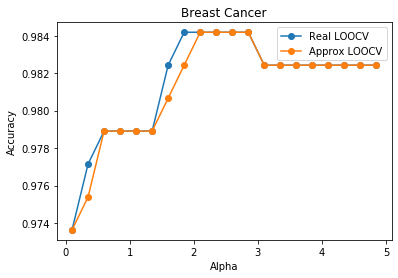

In [8]:
fig, ax = plt.subplots()
ax.plot(alphas, scores, label='Real LOOCV', marker='o')
ax.plot(alphas, scores_approx, label='Approx LOOCV', marker='o')
ax.set_xlabel('Alpha')
ax.set_ylabel('Accuracy')
ax.set_title("Breast Cancer")
ax.legend()

In [9]:
scores_approx = [compute_aloocv(X, y, alpha, 'loglikelihood') for alpha in alphas]
scores = [compute_loocv(X, y, alpha, 'loglikelihood') for alpha in alphas]

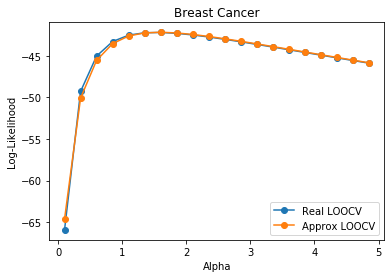

In [10]:
fig, ax = plt.subplots()
ax.plot(alphas, scores, label='Real LOOCV', marker='o')
ax.plot(alphas, scores_approx, label='Approx LOOCV', marker='o')
ax.set_xlabel('Alpha')
ax.set_ylabel('Log-Likelihood')
ax.set_title("Breast Cancer")
ax.legend()

## Validate on Haberman's survival dataset
*Available from https://archive.ics.uci.edu/ml/datasets/Haberman's+Survival*

In [11]:
column_names = ['age', 'year', 'node_count', 'status']
df = pd.read_csv('../../../dataset/haberman/haberman.data', names=column_names)
X = np.array(df.iloc[:,:-1].values, dtype=float)
y = np.array(df.iloc[:,-1].values, dtype=int)
y -= 1
X = StandardScaler().fit_transform(X)

In [12]:
alphas = np.arange(0.1, 25, 0.5)

In [13]:
scores_approx = [compute_aloocv(X, y, alpha, 'accuracy') for alpha in alphas]
scores = [compute_loocv(X, y, alpha, 'accuracy') for alpha in alphas]

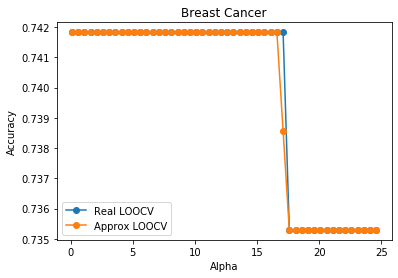

In [14]:
fig, ax = plt.subplots()
ax.plot(alphas, scores, label='Real LOOCV', marker='o')
ax.plot(alphas, scores_approx, label='Approx LOOCV', marker='o')
ax.set_xlabel('Alpha')
ax.set_ylabel('Accuracy')
ax.set_title("Breast Cancer")
ax.legend()

In [15]:
scores_approx = [compute_aloocv(X, y, alpha, 'loglikelihood') for alpha in alphas]
scores = [compute_loocv(X, y, alpha, 'loglikelihood') for alpha in alphas]

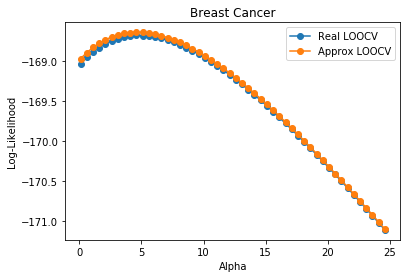

In [16]:
fig, ax = plt.subplots()
ax.plot(alphas, scores, label='Real LOOCV', marker='o')
ax.plot(alphas, scores_approx, label='Approx LOOCV', marker='o')
ax.set_xlabel('Alpha')
ax.set_ylabel('Log-Likelihood')
ax.set_title("Breast Cancer")
ax.legend()